# Gesture Recognition
In this group project, we are buildong a 3D Conv model that will be able to predict the 5 gestures correctly. 

In [2]:
import numpy as np
import os
#from scipy.misc import imread, imresize
from skimage.transform import resize
from skimage.io import imread
import datetime
import os
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import imageio

We set the random seed so that the results don't vary drastically.

In [11]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
#tf.set_random_seed(30)
tf.random.set_seed(30)
import keras

print(keras.__version__)

3.4.1


In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [12]:
train_doc = np.random.permutation(open('Project_data\\train.csv').readlines())
val_doc = np.random.permutation(open('Project_data\\val.csv').readlines())
batch_size = 32

Preview Images

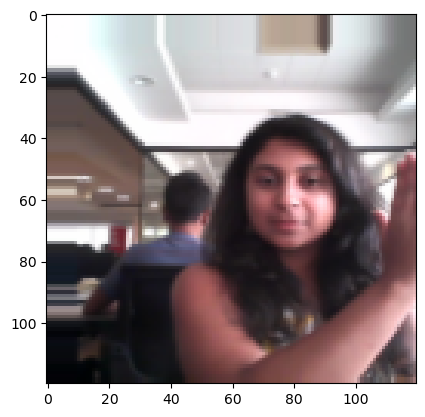

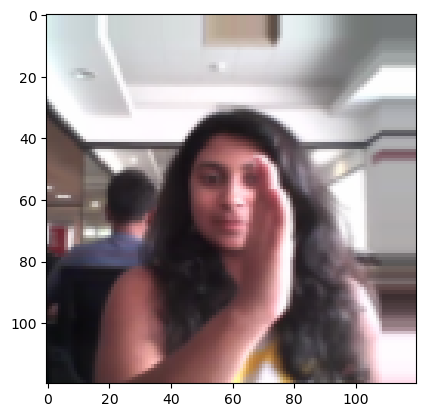

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    zoom_range=0.1,
    zca_whitening=True,
    width_shift_range=0.1,
    height_shift_range=0.1)
image1 = imageio.imread("Project_data\\val\\WIN_20180907_16_20_53_Pro_Right Swipe_new\\WIN_20180907_16_20_53_Pro_00012.png")
#160 by 120
image2 = imageio.imread("Project_data\\val\\WIN_20180907_16_20_53_Pro_Right Swipe_new\\WIN_20180907_16_20_53_Pro_00032.png")
#crop the images and resize them. Note that the images are of 2 different shape 
#and the conv3D will throw error if the inputs in a batch have different shapes                    
#print(image1.shape, image2.shape)
image1 = resize(image1, (120, 120), anti_aliasing=True)
image1 = datagen.random_transform(image1)                   
plt.imshow(image1)
plt.show()
image2 = resize(image2, (120, 120), anti_aliasing=True)
image2 = datagen.random_transform(image2)                 
plt.imshow(image2)
plt.show()

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [13]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [2,4,6,8,10,12,14,16,18,20,22,24,26]
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t) // batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,13,80,80,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    image = resize(image,(80,80)).astype(np.float32)
                    
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255 #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if len(t) % batch_size != 0:
            batch_data = np.zeros((batch_size,13,80,80,3)) 
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    image = resize(image,(80,80)).astype(np.float32)
                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1 
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield does    

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [14]:
curr_dt_time = datetime.datetime.now()
train_path = 'Project_data\\train'
val_path = 'Project_data\\val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 20


## First Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [15]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.layers import Dropout

#write your model here
model = Sequential()
model.add(Conv3D(32, (3, 3, 3), padding='same',
         input_shape=(13,80,80,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(128, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(64,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(5,activation='softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [16]:
optimiser = 'sgd'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 13, 80, 80, 32) │         2,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 13, 80, 80, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 13, 80, 80, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 6, 40, 40, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 6, 40, 40, 64)  │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 6, 40, 40, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 6, 40, 40, 64)  │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 3, 20, 20, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 3, 20, 20, 128) │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 3, 20, 20, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 3, 20, 20, 128) │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 1, 10, 10, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,638,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,733,509 (6.61 MB)

 Trainable params: 1,732,677 (6.61 MB)

 Non-trainable params: 832 (3.25 KB)

None


Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [17]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [18]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.weights.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='auto',save_freq="epoch")# period=1)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [19]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [30]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, initial_epoch=0)

Source path =  Project_data\train ; batch size = 32
Epoch 1/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.3354 - loss: 1.9768Source path =  Project_data\val ; batch size = 32

Epoch 1: val_loss improved from inf to 1.56954, saving model to model_init_2024-07-1715_08_15.591897/model-00001-1.77918-0.36607-1.56954-0.29688.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 61s 3s/step - categorical_accuracy: 0.3368 - loss: 1.9679 - val_categorical_accuracy: 0.2969 - val_loss: 1.5695 - learning_rate: 0.0100
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.4578 - loss: 1.4164
Epoch 2: val_loss did not improve from 1.56954
21/21 ━━━━━━━━━━━━━━━━━━━━ 54s 3s/step - categorical_accuracy: 0.4594 - loss: 1.4120 - val_categorical_accuracy: 0.1562 - val_loss: 1.8765 - learning_rate: 0.0100
Epoch 3/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.6190 - loss: 0.9346
Epoch 3: val_loss did not improve from 1.56954
21/21 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/ste

In [33]:
print("Total Params:", model.count_params())

Total Params: 1733509


<Figure size 1000x1000 with 0 Axes>

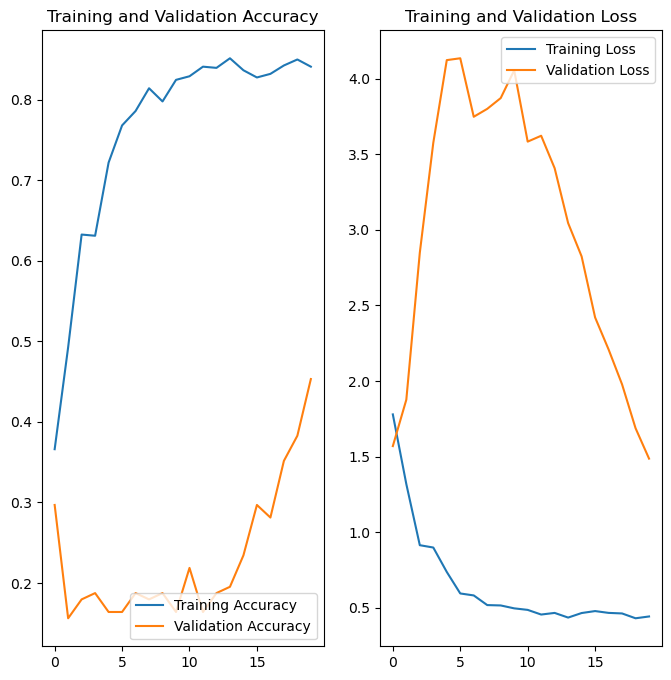

In [34]:

plt.figure(figsize = (10,10))

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Model 2
In above model we see the validation accuracy is varing wildly. Adding more epochs may give the stable validation accuracy. Before doing that we would try what effect batch_size of 64 have on the model. 
For this model we will try batch_zise and 64

In [20]:
new_batch_size = 64
train_generator = generator(train_path, train_doc, new_batch_size)
val_generator = generator(val_path, val_doc, new_batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.weights.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='auto',save_freq="epoch")# period=1)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

optimiser = 'sgd'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 13, 80, 80, 32) │         2,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 13, 80, 80, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 13, 80, 80, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 6, 40, 40, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 6, 40, 40, 64)  │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 6, 40, 40, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 6, 40, 40, 64)  │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 3, 20, 20, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 3, 20, 20, 128) │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 3, 20, 20, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 3, 20, 20, 128) │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 1, 10, 10, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,638,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,733,509 (6.61 MB)

 Trainable params: 1,732,677 (6.61 MB)

 Non-trainable params: 832 (3.25 KB)

None


In [41]:

num_epochs2=30
history2 = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs2, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, initial_epoch=0)


Source path =  Project_data\train ; batch size = 64
Epoch 1/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - categorical_accuracy: 0.8581 - loss: 0.4122Source path =  Project_data\val ; batch size = 64

Epoch 1: val_loss improved from inf to 1.18022, saving model to model_init_2024-07-1715_08_15.591897/model-00001-0.41113-0.86161-1.18022-0.53906.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 113s 5s/step - categorical_accuracy: 0.8583 - loss: 0.4121 - val_categorical_accuracy: 0.5391 - val_loss: 1.1802 - learning_rate: 0.0100
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - categorical_accuracy: 0.8955 - loss: 0.3272
Epoch 2: val_loss did not improve from 1.18022
21/21 ━━━━━━━━━━━━━━━━━━━━ 103s 5s/step - categorical_accuracy: 0.8954 - loss: 0.3275 - val_categorical_accuracy: 0.5000 - val_loss: 1.3002 - learning_rate: 0.0100
Epoch 3/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - categorical_accuracy: 0.9072 - loss: 0.2811
Epoch 3: val_loss did not improve from 1.18022
21/21 ━━━━━━━━━━━━━━━━━━━━ 92s 4s/s

<Figure size 1000x1000 with 0 Axes>

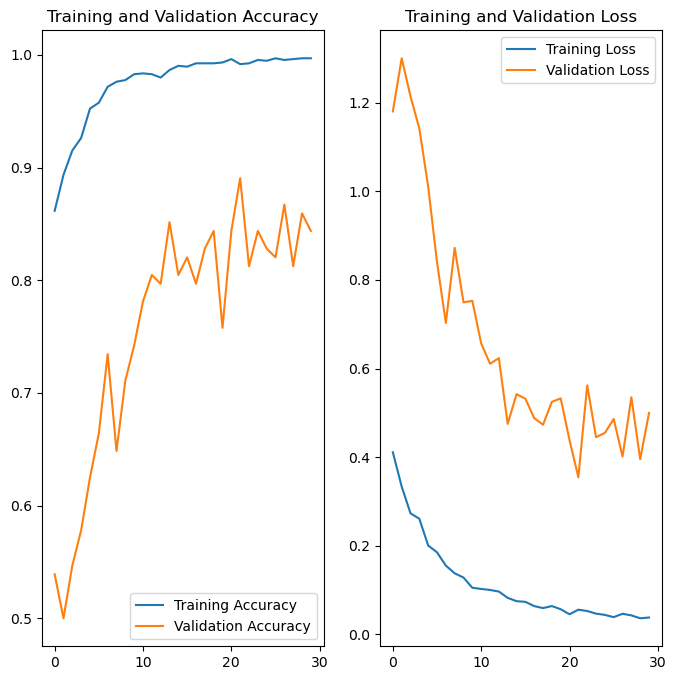

In [42]:

plt.figure(figsize = (10,10))

acc = history2.history['categorical_accuracy']
val_acc = history2.history['val_categorical_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs_range = range(num_epochs2)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Model 3

As we saw the validation accuracy is increased in the previous model with higher number of epochs and batch size. Now we can experiment if we can get better results by improving the image resolution. Previously we tried with the 80 * 80 image resolution and only 13 images from the set we considered. Now we will use 120 * 120 image resolution and we will use 20 images from each video frames.

In [21]:
def new_generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [0,2,4,6,8,10,11,12,13,14,15,16,17,18,19,20,22,24,26,28]
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t) // batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,20,120,120,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    image = resize(image,(120,120)).astype(np.float32)
                    
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255 #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if len(t) % batch_size != 0:
            batch_data = np.zeros((batch_size,20,120,120,3)) 
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    image = resize(image,(120,120)).astype(np.float32)
                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1 
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield does    

In [22]:
curr_dt_time = datetime.datetime.now()
train_path = 'Project_data\\train'
val_path = 'Project_data\\val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 20


In [45]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.layers import Dropout

#write your model here
model = Sequential()
model.add(Conv3D(32, (3, 3, 3), padding='same',
         input_shape=(20,120,120,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(128, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(64,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(5,activation='softmax'))

In [24]:
new_batch_size = 32
train_generator = generator(train_path, train_doc, new_batch_size)
val_generator = generator(val_path, val_doc, new_batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.weights.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='auto',save_freq="epoch")# period=1) period=1)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

optimiser = 'sgd'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 13, 80, 80, 32) │         2,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 13, 80, 80, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 13, 80, 80, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 6, 40, 40, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 6, 40, 40, 64)  │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 6, 40, 40, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 6, 40, 40, 64)  │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 3, 20, 20, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 3, 20, 20, 128) │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 3, 20, 20, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 3, 20, 20, 128) │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 1, 10, 10, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,638,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,733,509 (6.61 MB)

 Trainable params: 1,732,677 (6.61 MB)

 Non-trainable params: 832 (3.25 KB)

None


In [25]:
steps_per_epoch=0
validation_steps=0
if (num_train_sequences%new_batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/new_batch_size)
else:
    steps_per_epoch = (num_train_sequences//new_batch_size) + 1

if (num_val_sequences%new_batch_size) == 0:
    validation_steps = int(num_val_sequences/new_batch_size)
else:
    validation_steps = (num_val_sequences//new_batch_size) + 1

In [49]:
num_epochs3=20
history3 = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs3, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, initial_epoch=0)

Source path =  Project_data\train ; batch size = 32
Epoch 1/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 1.0000 - loss: 0.0329Source path =  Project_data\val ; batch size = 32

Epoch 1: val_loss improved from inf to 0.54074, saving model to model_init_2024-07-1715_08_15.591897/model-00001-0.03803-1.00000-0.54074-0.84375.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 55s 3s/step - categorical_accuracy: 1.0000 - loss: 0.0331 - val_categorical_accuracy: 0.8438 - val_loss: 0.5407 - learning_rate: 0.0100
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.9992 - loss: 0.0478
Epoch 2: val_loss improved from 0.54074 to 0.48584, saving model to model_init_2024-07-1715_08_15.591897/model-00002-0.04349-0.99702-0.48584-0.85156.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 51s 3s/step - categorical_accuracy: 0.9991 - loss: 0.0476 - val_categorical_accuracy: 0.8516 - val_loss: 0.4858 - learning_rate: 0.0100
Epoch 3/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_acc

<Figure size 1000x1000 with 0 Axes>

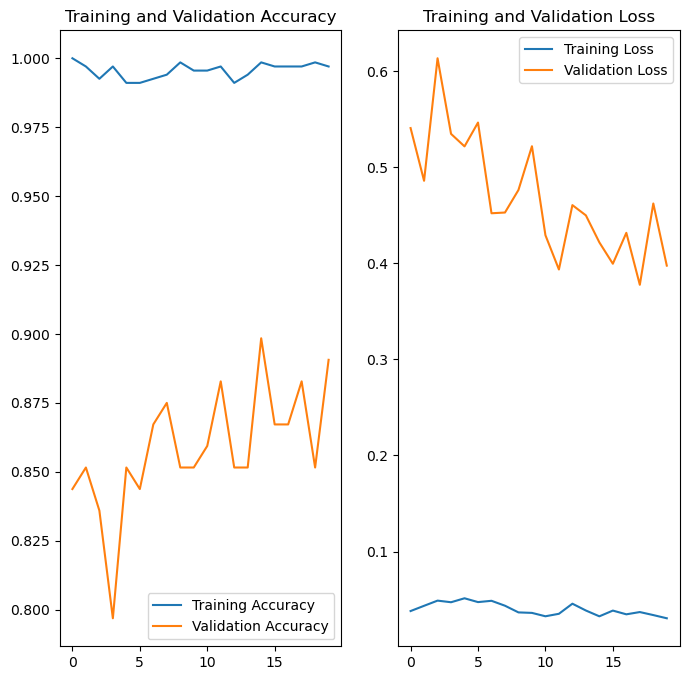

In [50]:

plt.figure(figsize = (10,10))

acc = history3.history['categorical_accuracy']
val_acc = history3.history['val_categorical_accuracy']

loss = history3.history['loss']
val_loss = history3.history['val_loss']

epochs_range = range(num_epochs3)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Model 4
In above model we can see the model is overfitting as the validation accuracy is dropped drastically. We will now experiment if increasing the no of epochs help to increase the validation accuracy as we saw in the first two models. Or we will need to go for augmenting to create more training dat to avoid overfitting.

In [27]:
num_epochs4=40
history4 = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs4, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, initial_epoch=0)

Source path =  Project_data\train ; batch size = 32
Epoch 1/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.3354 - loss: 1.9768Source path =  Project_data\val ; batch size = 32

Epoch 1: val_loss improved from inf to 1.56954, saving model to model_init_2024-07-1811_15_15.105457/model-00001-1.77918-0.36607-1.56954-0.29688.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 75s 4s/step - categorical_accuracy: 0.3368 - loss: 1.9679 - val_categorical_accuracy: 0.2969 - val_loss: 1.5695 - learning_rate: 0.0100
Epoch 2/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.4578 - loss: 1.4164
Epoch 2: val_loss did not improve from 1.56954
21/21 ━━━━━━━━━━━━━━━━━━━━ 57s 3s/step - categorical_accuracy: 0.4594 - loss: 1.4120 - val_categorical_accuracy: 0.1562 - val_loss: 1.8765 - learning_rate: 0.0100
Epoch 3/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.6190 - loss: 0.9346
Epoch 3: val_loss did not improve from 1.56954
21/21 ━━━━━━━━━━━━━━━━━━━━ 51s 3s/ste

<Figure size 1000x1000 with 0 Axes>

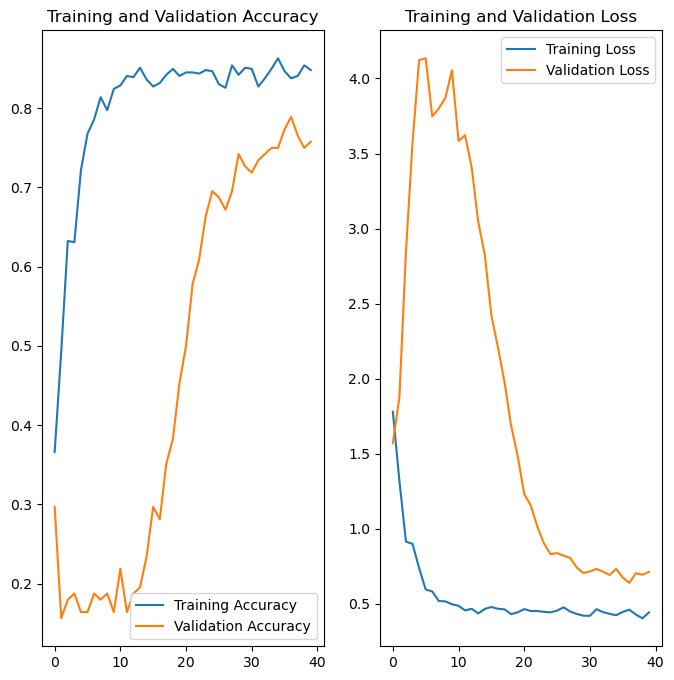

In [31]:

plt.figure(figsize = (10,10))

acc = history4.history['categorical_accuracy']
val_acc = history4.history['val_categorical_accuracy']

loss = history4.history['loss']
val_loss = history4.history['val_loss']

epochs_range = range(num_epochs4)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Model 5

In previous model we saw that validation accuracy is increased compared to the previous model, but it is not able to increase above the threshold of 0.75 where the training accuracy have reached 0.83. This concludes no of epochs increased do not help much in improving the model which is overfitting.

Now we will try to implement the CNN + LSTM model and will compare the results with the second model which had highest validation accuracy.


In [53]:
from keras.layers import LSTM

#write your model here
model = Sequential()
model.add(Conv3D(32, (3, 3, 3), padding='same',
         input_shape=(13,80,80,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(128, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(TimeDistributed(Flatten()))
model.add(LSTM(128))
model.add(Dropout(0.5))

model.add(Dense(64,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(5,activation='softmax'))

In [57]:
batch_size = 32
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.weights.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='auto',save_freq="epoch")# period=1) period=1)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

optimiser = 'sgd'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_9 (Conv3D)               │ (None, 13, 80, 80, 32) │         2,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 13, 80, 80, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 13, 80, 80, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_9 (MaxPooling3D)  │ (None, 6, 40, 40, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_10 (Conv3D)              │ (None, 6, 40, 40, 64)  │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 6, 40, 40, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 6, 40, 40, 64)  │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_10 (MaxPooling3D) │ (None, 3, 20, 20, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_11 (Conv3D)              │ (None, 3, 20, 20, 128) │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 3, 20, 20, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 3, 20, 20, 128) │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_11 (MaxPooling3D) │ (None, 1, 10, 10, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 1, 12800)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │     6,619,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,714,117 (25.61 MB)

 Trainable params: 6,713,541 (25.61 MB)

 Non-trainable params: 576 (2.25 KB)

None


In [55]:
steps_per_epoch=0
validation_steps=0
if (num_train_sequences%new_batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/new_batch_size)
else:
    steps_per_epoch = (num_train_sequences//new_batch_size) + 1

if (num_val_sequences%new_batch_size) == 0:
    validation_steps = int(num_val_sequences/new_batch_size)
else:
    validation_steps = (num_val_sequences//new_batch_size) + 1

In [38]:
num_epochs5=20
history5 = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs5, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, initial_epoch=0)

Source path =  Project_data\train ; batch size = 32
Epoch 1/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.8307 - loss: 0.4890Source path =  Project_data\val ; batch size = 32

Epoch 1: val_loss improved from inf to 0.83781, saving model to model_init_2024-07-1811_15_15.105457/model-00001-0.52709-0.80952-0.83781-0.64062.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 57s 3s/step - categorical_accuracy: 0.8298 - loss: 0.4908 - val_categorical_accuracy: 0.6406 - val_loss: 0.8378 - learning_rate: 0.0100
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.8183 - loss: 0.5046
Epoch 2: val_loss improved from 0.83781 to 0.69594, saving model to model_init_2024-07-1811_15_15.105457/model-00002-0.48365-0.83482-0.69594-0.75000.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 56s 3s/step - categorical_accuracy: 0.8190 - loss: 0.5036 - val_categorical_accuracy: 0.7500 - val_loss: 0.6959 - learning_rate: 0.0100
Epoch 3/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_acc

<Figure size 1000x1000 with 0 Axes>

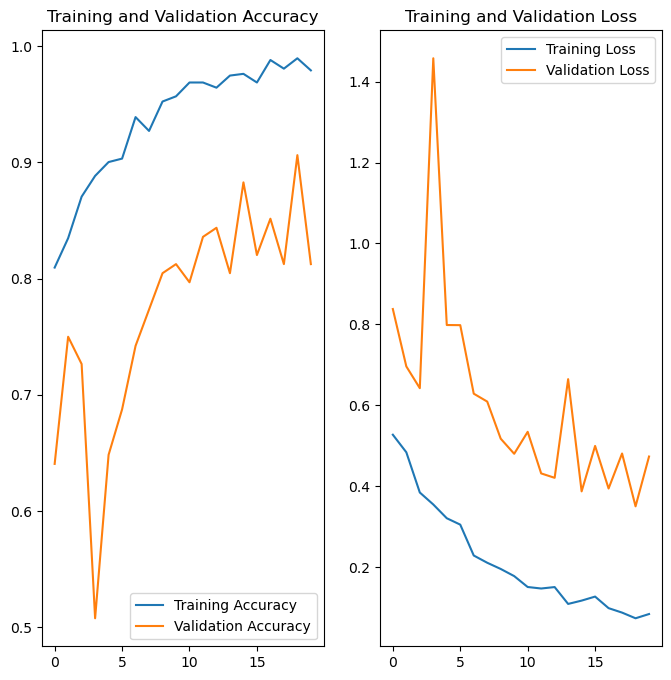

In [41]:

plt.figure(figsize = (10,10))

acc = history5.history['categorical_accuracy']
val_acc = history5.history['val_categorical_accuracy']

loss = history5.history['loss']
val_loss = history5.history['val_loss']

epochs_range = range(num_epochs5)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Model 6

In previous model model is having overall less training and validation accuracy, but we see steady trend in increasing the training and validation accuracy. Adding more epochs can help here to further improve the accuracy.

In [58]:
num_epochs6=40
history6 = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs6, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, initial_epoch=0)

Source path =  Project_data\train ; batch size = 32
Epoch 1/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - categorical_accuracy: 0.2288 - loss: 2.1500Source path =  Project_data\val ; batch size = 32

Epoch 1: val_loss improved from inf to 1.60046, saving model to model_init_2024-07-1811_15_15.105457/model-00001-1.95474-0.28125-1.60046-0.27344.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 200s 10s/step - categorical_accuracy: 0.2312 - loss: 2.1411 - val_categorical_accuracy: 0.2734 - val_loss: 1.6005 - learning_rate: 0.0100
Epoch 2/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - categorical_accuracy: 0.3272 - loss: 1.8010
Epoch 2: val_loss improved from 1.60046 to 1.59150, saving model to model_init_2024-07-1811_15_15.105457/model-00002-1.72191-0.34375-1.59150-0.22656.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 180s 9s/step - categorical_accuracy: 0.3279 - loss: 1.7974 - val_categorical_accuracy: 0.2266 - val_loss: 1.5915 - learning_rate: 0.0100
Epoch 3/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - categorical_

<Figure size 1000x1000 with 0 Axes>

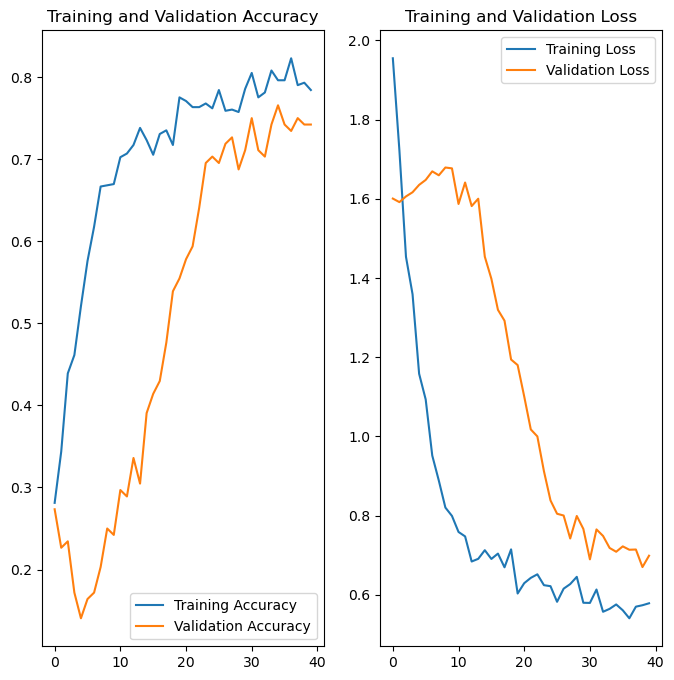

In [59]:
plt.figure(figsize = (10,10))

acc = history6.history['categorical_accuracy']
val_acc = history6.history['val_categorical_accuracy']

loss = history6.history['loss']
val_loss = history6.history['val_loss']

epochs_range = range(num_epochs6)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

This model did reach good training as well as validation accuracy.
Training Accuracy = 0.77
Validation Accuracy = 0.74